In [1]:
import pandas as pd
from plot_split_loader import plotwise_split, data_merge, plotwise_kfold

train1, train2, test1, test2 = plotwise_split()

c:\Users\duffi\OneDrive\Documents\2024JobHuntBootCamps\Trees Project\Erdos_Trees\machine_learning\plot_split_loader.py:115: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(trimmed_data_path)


## On to the data science!

#### K Nearest Neighbors Classifying Dead Or Alive

In [2]:
train = data_merge(train1, train2,
    indicator_features = ["LAT", "LON", "ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "CR_pre_burn",
                         "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS",
                         "BURN_AREA_TOTAL"])
test = data_merge(test1, test2,
    indicator_features = ["ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "CR_pre_burn",
                         "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS",
                         "BURN_AREA_TOTAL"])

print("-"*60)
train.info(verbose=True, show_counts=True)

SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7541 entries, 0 to 9711
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  7541 non-null   int64  
 1   PLOT                7541 non-null   int64  
 2   LAT                 7541 non-null   float64
 3   LON                 7541 non-null   float64
 4   ALIVE_pre_burn      7541 non-null   int64  
 5   CULL_pre_burn       6784 non-null   float64
 6   DIA_pre_burn        7541 non-null   float64
 7   HT_pre_burn         7541 non-null   float64
 8   CR_pre_burn         7541 non-null   float64
 9   DRYBIO_AG_pre_burn  7541 non-null   float64
 10  ELEV                7541 non-null   float64
 11  SOFTW

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
# Getting a large-scale view of the training data outcomes.
fig = px.scatter_map(train, lat='LAT', lon='LON', color='ALIVE_post_burn',
                     center=dict(lat=47.3, lon=-120.5), zoom=5.3)

fig.show()
# Many of the dots are stacked on top of each other, because all trees on the same PLOT
# inherit the same LAT and LON.

These look somewhat mixed together; I was afraid that there would be clear swaths where everything died and different patches where everything lived.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor

from sklearn.metrics import confusion_matrix, accuracy_score, root_mean_squared_error, log_loss

import matplotlib.pyplot as plt

Let's look at the accuracy of K Nearest Neighbors in predicting whether a tree would survive:

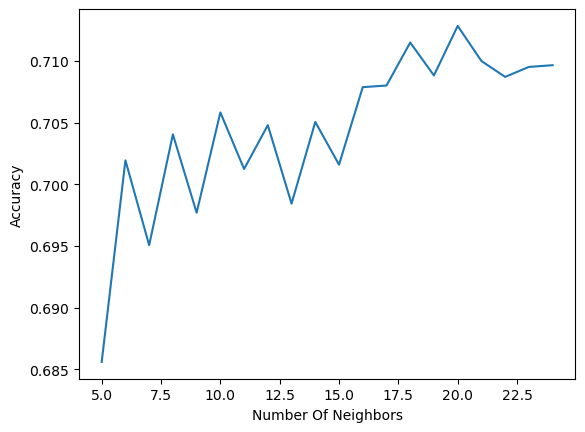

In [17]:
# Removing rows which have no CR data to use this as a feature
# I also ran this with CULL_pre_burn as a health indicator, that didn't actually improve the classifier
train_no_nan = train.dropna(axis = 0, subset = ["CR_pre_burn"])

splits = 5
# kfold = StratifiedKFold(splits, random_state=216, shuffle=True)
# indicator_features = ["ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "DRYBIO_AG_pre_burn",
#                       "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS", "BURN_AREA_TOTAL"]
indicator_features = ["DIA_pre_burn", "HT_pre_burn", "DRYBIO_AG_pre_burn", "CR_pre_burn",
                      "ELEV", "SOFTWOOD", "BURN_AREA_TOTAL"]

mean_accs = []
for k in range(5,25): # neighbor number
    classifier_pipe = Pipeline([("Scaler", StandardScaler()), 
                                ("KNN Classifier", KNeighborsClassifier(n_neighbors=k))])
    
    acc_list = []
    for train_index, test_index in plotwise_kfold(train_no_nan):
        t_train = train_no_nan.iloc[train_index]
        t_val = train_no_nan.iloc[test_index]
        
        classifier_pipe.fit(t_train[indicator_features], t_train["ALIVE_post_burn"])
        pred = classifier_pipe.predict(t_val[indicator_features])
        acc_list.append(accuracy_score(t_val["ALIVE_post_burn"], pred))
    
    # print(f"{k} Neighbors accuracy scores: {acc_list} \n")
    # print(f"Mean accuracy for {k} Neighbors: {sum(acc_list)/len(acc_list)} \n")
    mean_accs.append(sum(acc_list)/len(acc_list))

plt.plot(range(5,25),mean_accs)
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.show()

Using different subsets of features, the best results under the new plotwise split are as follows: 71.3 using ["DIA_pre_burn", "HT_pre_burn", "DRYBIO_AG_pre_burn", "CR_pre_burn", "ELEV", "SOFTWOOD", "BURN_AREA_TOTAL"] and 20 neighbors.

The dummy classifier here has 71.2% accuracy, so they are roughly equivalent, which isn't good.

In [ ]:
# Exploring some other metrics for the most accurate classifier found above
k = 20
classifier_pipe = Pipeline([("Scaler", StandardScaler()), 
                            ("KNN Classifier", KNeighborsClassifier(n_neighbors=k))])
dummy = DummyClassifier()
    
knn_losses = []
dummy_losses = []
for train_index, test_index in plotwise_kfold(train_no_nan):
    t_train = train_no_nan.iloc[train_index]
    t_val = train_no_nan.iloc[test_index]
        
    classifier_pipe.fit(t_train[indicator_features], t_train["ALIVE_post_burn"])
    pred = classifier_pipe.predict_proba(t_val[indicator_features])
    knn_losses.append(log_loss(t_val["ALIVE_post_burn"], pred))

    dummy.fit(t_train[indicator_features], t_train["ALIVE_post_burn"])
    dummy_pred = dummy.predict_proba(t_val[indicator_features])
    dummy_losses.append(log_loss(t_val["ALIVE_post_burn"], dummy_pred))
    
print(f"{k} Neighbors log losses: {knn_losses}")
print(f"Mean log loss for {k} Neighbors: {sum(knn_losses)/len(knn_losses)} \n")

print(f"Dummy log losses: {dummy_losses}")
print(f"Mean log loss for dummy classifier: {sum(dummy_losses)/len(dummy_losses)} \n")

20 Neighbors log losses: [1.195336965052864, 1.5173136238242282, 0.8610727032541183, 1.0372987915127307, 1.1359221042633085]
Mean log loss for 20 Neighbors: 1.14938883758145 

Dummy log losses: [0.5932034130529579, 0.5603762434943793, 0.7205959725241555, 0.5929519135756399, 0.5567876808526712]
Mean log loss for dummy classifier: 0.6047830446999607 



Well, despite being roughly as accurate as a dummy classifier, this KNN model is certainly less well-calibrated. K Nearest Neighbors doesn't seem to be a good model to use for this data; we would at least need a bigger sample.

Before changing our splitting mechanism to go by plot, the highest performing model was this:
 - 81.9% with ["ELEV", "SOFTWOOD", "BURN_AREA_TOTAL"] and 10 neighbors

But all three of these things seemed like they would bias towards trees that were literal "nearest neighbors", and indeed when we removed the literal neighbors of the test trees from the train data, performance crashed to what you see above.

In [18]:
# Checking (lack of) diversity in burn area values
pd.DataFrame(train.BURN_AREA_TOTAL.value_counts())

,count
BURN_AREA_TOTAL,
1.418123e+09,1295
1.719504e+08,685
2.055347e+09,560
2.400386e+09,524
2.204000e+08,434
...,...
1.488763e+08,4
1.384197e+08,2
6.821937e+07,2


Let's see how the best model from above performs on the test set anyway.

In [ ]:
# Fitting the best model to the entire training data set:
classifier_pipe = Pipeline([("Scaler", StandardScaler()), 
                            ("KNN Classifier", KNeighborsClassifier(n_neighbors=20))])
best_classifier = classifier_pipe.fit(train_no_nan[indicator_features], train_no_nan["ALIVE_post_burn"])

# Running the model on the test set now that it's been (somewhat) tuned:
test_no_nan = test.dropna(axis = 0, subset = ["CULL_pre_burn"])
preds = best_classifier.predict(test_no_nan[indicator_features])
print(accuracy_score(test_no_nan["ALIVE_post_burn"], preds))

0.7442977190876351


At least it was consistent (and even improved a little), so it isn't over- or under-fit.